In [7]:
import pandas as pd
import numpy as np
%matplotlib inline
 

In [11]:
#Load specific forecasting tools

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

#Ignore harless warnings
import warnings
warnings.filterwarnings('ignore')

#load datasets

df = pd.read_csv('../Data/M2SLMoneyStock.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../Data/PCEPersonalSpending.csv',index_col='Date',parse_dates=True)

sp.index.freq = 'MS'

In [13]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [14]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [15]:
df = df.join(sp)

In [16]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


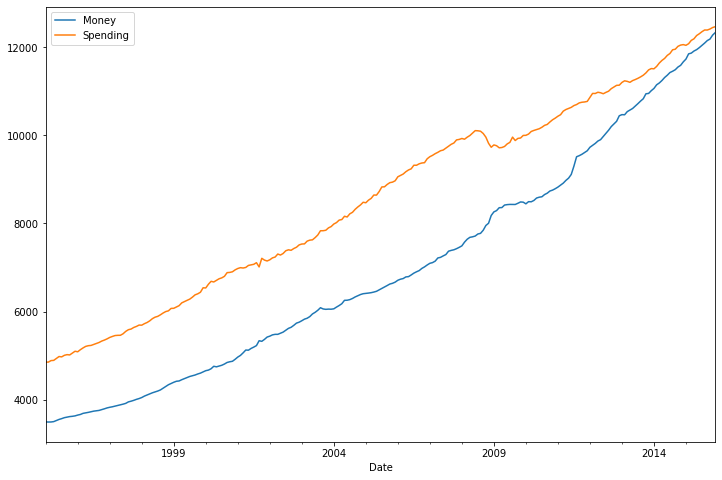

In [17]:
df.plot(figsize=(12,8))

In [19]:
# function for running the augmented dickey fuller test
 
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [20]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [21]:
df_transformed = df.diff()

In [22]:
df_transformed.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


In [26]:
#we differenced twice because only the 'spending' column
#was made stationary by the first differencing the
#'money' column remained non-staionary

df_transformed = df_transformed.diff().dropna()

In [27]:
df_transformed

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7
...,...,...
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5


In [28]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [29]:
#no of observations
nobs = 12

In [30]:
train = df_transformed[:-nobs]

In [31]:
test = df_transformed[-nobs:]

## GRID SEARCH FOR ORDER p AR of VAR model

In [33]:
model = VAR(train)

for p in range(8):
    
    results = model.fit(p)
    print(f'ORDER of {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER of 0
AIC: 14.74710921809045


ORDER of 1
AIC: 14.178610495220896


ORDER of 2
AIC: 13.955189367163705


ORDER of 3
AIC: 13.849518291541038


ORDER of 4
AIC: 13.827950574458281


ORDER of 5
AIC: 13.78730034460964


ORDER of 6
AIC: 13.799076756885807


ORDER of 7
AIC: 13.797638727913972




In [34]:
results = model.fit(5)

In [35]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 20, Apr, 2020
Time:                     13:45:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [ ]:
#grab 5 lagged values right before the test starts
#they should a numpy array

In [38]:
lagged_values = train.values[-5:]

z = results.forecast(y=lagged_values,steps=12)

In [39]:
idx = pd.date_range('2015-01-01',periods=12,freq='MS')

In [42]:
df_forecast = pd.DataFrame(data=z,index=idx,columns=['Money_2d','Spending_2d'])

In [43]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [44]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()